# A Model for Rankings

$r_u(t)$ = the ranking of university $u$ at time $t$.

We'll use $t$ to represent time, which will generally think of
as discrete. Thus $r_u(t-1)$ is university $u$'s ranking the year before.

Let $M$ be the number of attributes in the ranking.

$y_{i,u}(t)$ = the value of university $u$'s i-th attribute,
where $i$ ranges from 1 to $M$.

$w_i(t)$ is the weightage given to attribute $i$ in the ranking.
This generally does not change frequently.

We will now define the _score_ of a university as

$$
     \mu_u(t) = \sum_{i} w_i(t) V_i(y_{i,u}(t))
$$

In [1]:
from ranking_system import *

number_of_time_steps = 10
number_of_universities = 2

# Create a list of attributes (name, ranking weight)
attributes = [Attribute('research', 0.7), Attribute('faculty', 0.3)]

# Create a new model
model = RankingModel(number_of_universities, attributes, random_seed=13579)

# Run the model
model.run(number_of_time_steps)

# Display the scores and ranking
display_ranking(model, all_rows=False)

,University,Time,Rank,Score,Normalized Score
0,University 1,1,2,71.82,74
1,University 2,1,1,96.58,100
2,University 1,2,2,99.13,98
3,University 2,2,1,100.87,100
...,...,...,...,...,...
16,University 1,9,1,173.45,100
17,University 2,9,2,166.30,96
18,University 1,10,1,177.76,100
19,University 2,10,2,167.39,94


<IPython.core.display.Javascript object>


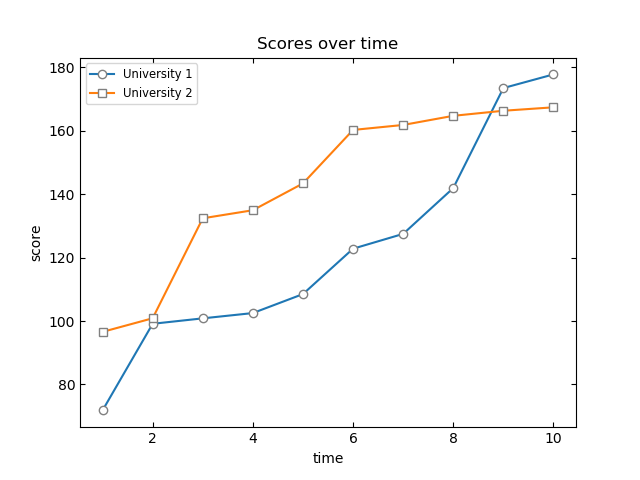

In [2]:
%matplotlib notebook

# Plot the university score over time
line_plot(get_score_by_agent(model), 'time', 'score', 'Scores over time')